In [7]:
import numpy as np
import matplotlib.pyplot as plt

import nibabel as nib

In [21]:
x = np.load("prediction_test.npy")
x = np.squeeze(x)

In [22]:
nib.save(nib.Nifti1Image(x,np.eye(4)),"output.nii.gz")

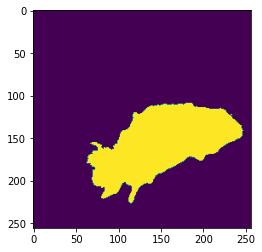

In [35]:
plt.imshow(x[6,:,:])